# GAN dogs project


In [1]:
%matplotlib inline

import numpy as np
import torch 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [2]:
device = 'cuda:3'

### Loading data and minimal preproccessing 


In [3]:
import torch.utils.data as data 
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms 

# if 64*64
batch_size = 64 
# if 128*128 
# batch_size = 128


transform = transforms.Compose([
    # for 64*64
    transforms.Resize(64),
    transforms.CenterCrop(64),

    # if for 128*128 images uncommment below 
    # transforms.Resize(128),
    # transforms.CenterCrop(128),
    
    transforms.ToTensor()
])

data_path = './after_4_bis/'
train_data = datasets.ImageFolder(root=data_path, transform=transform)
train_loader = data.DataLoader(train_data, batch_size=batch_size, num_workers=0)


### This is how the dogs looks 



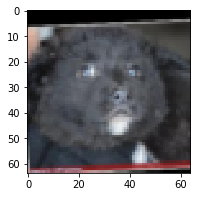

In [4]:
# print one img from a batch as an example 

data_iter = iter(train_loader)
images, _=  data_iter.next()
rand_int = random.randint(0, batch_size-1)
 
fig = plt.figure(figsize=(3, 3))
img = images[rand_int].numpy()
img = np.transpose(img, (1,2,0))

plt.imshow(img)


## Model and helper functions

In [5]:
import torch.nn as nn

class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        
     
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels=3,
                                  out_channels=conv_dim,
                                  kernel_size=4,
                                  stride=2,
                                  padding=1,
                                  bias=False)  ,
                        #  IF TRAINING 64*64 
                        nn.LeakyReLU(0.2))
                        # If training 128*128 uncomment SELU 
                        # nn.SELU(inplace=True))
      
        self.conv2 = nn.Sequential(
                            nn.Conv2d(
                                in_channels=conv_dim,
                                out_channels=conv_dim*2,
                                kernel_size=4,
                                stride=2,
                                padding=1, 
                                bias=False),
                            #  IF TRAINING 64*64 
                            nn.BatchNorm2d(conv_dim*2),
                            nn.LeakyReLU(0.2))
                            
                            # If training 128*128 uncomment SELU 
                            # nn.SELU(inplace=True))


       
        self.conv3 = nn.Sequential(
                        nn.Conv2d(
                            in_channels=conv_dim*2,
                            out_channels=conv_dim*4,
                            kernel_size=4,
                            stride=2,
                            padding=1,
                            bias=False),

                        #  IF TRAINING with  64*64 
                        nn.BatchNorm2d(conv_dim*4),
                        nn.LeakyReLU(0.2))
                        # If training 128*128 uncomment SELU 
                        # nn.SELU(inplace=True))
       
        self.conv4 = nn.Sequential(
                            nn.Conv2d(in_channels=conv_dim*4,
                                        out_channels=conv_dim*8,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1,
                                        bias=False),
                            #  IF TRAINING with  64*64 
                            nn.BatchNorm2d(conv_dim*8),
                            nn.LeakyReLU(0.2))

                            # if 128*128
                            # nn.SELU(inplace=True))
        # if 64*64 images
        self.fc = nn.Linear(conv_dim*8*4*4,1)   
        # if training with 128*128 uncomment below 
        # self.fc = nn.Linear(conv_dim*8*8*8,1)
        
        
       
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)

        # if 64*64
        out = out.view(-1, self.conv_dim*8*4*4)
        # if 128*128 uncomment below
        # out = out.view(-1, self.conv_dim*8*8*8)
        
        out = self.fc(out)
          
        return out

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim, conv_dim=32):
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        self.latent_dim = latent_dim
       
        # if 64*64 images 
        self.fc = nn.Linear(latent_dim, conv_dim*8*4*4)

        # if 128*128 images uncomment below 
        # self.fc = nn.Linear(latent_dim, conv_dim*8*8*8)
    
        self.ct1 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=conv_dim*8,
                                            out_channels=conv_dim*4,
                                            kernel_size=4,
                                            stride=2,
                                            padding=1,
                                            bias=False
                                            ),
                        # if 64*64 images
                        nn.BatchNorm2d(conv_dim*4),
                        nn.ReLU())
                        # if 128*128 uncomment below 
                        # nn.SELU(inplace=True))
 
        self.ct2 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=conv_dim*4,
                                            out_channels=conv_dim*2,
                                            kernel_size=4,
                                            stride=2,
                                            padding=1,
                                            bias=False
                                            ),
                        # if 64*64 images
                        nn.BatchNorm2d(conv_dim*2),
                        nn.ReLU())
                        # if training with 128*128 uncomment below
                        # nn.SELU(inplace=True))

        self.ct3 = nn.Sequential(

                        nn.ConvTranspose2d(in_channels=conv_dim*2,
                                            out_channels=conv_dim,
                                            kernel_size=4,
                                            stride=2,
                                            padding=1,
                                            bias=False),
                        # if 64*64
                        nn.BatchNorm2d(conv_dim),
                        nn.ReLU())
                        # if 128*128 
                        # nn.SELU(inplace=True))
    
                        
        self.ct4 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=conv_dim,
                                            out_channels=3,
                                            kernel_size=4,
                                            stride=2,
                                            padding=1,
                                            bias=False),
                        nn.Tanh())
       
       
    def forward(self, x):

        out = self.fc(x)
        # # if training with 64*64
        out = out.view(-1 , self.conv_dim*8, 4, 4)
        # if training with 128*128 
        # out = out.view(-1, self.conv_dim*8, 8, 8)
        
        out = self.ct1(out)
        out = self.ct2(out)
        out = self.ct3(out)
        out = self.ct4(out)
        
        return out 
        

In [7]:
conv_dim = 64
latent_dim = 100

D = Discriminator(conv_dim)
G = Generator(latent_dim=latent_dim, conv_dim=conv_dim)

D = D.to(device)
G = G.to(device)

print(D)
print('\n')
print(G)



Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
)


Generator(
  (fc): Linear(in_featur

### Helper functions

In [8]:
# for scaling images within range 

def scale(x, feature_range=(-1,1)):
    min, max = feature_range
    x = x*(max-min) + min
    return x

In [9]:
# for calculating D's and G's loss

def real_loss(D_output):
    batch_size = D_output.size(0)

    imgs = torch.ones(batch_size)

    imgs = imgs.to(device)

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_output.squeeze(), imgs)
    return loss

def fake_loss(D_output):
    batch_size = D_output.size(0)
    imgs = torch.zeros(batch_size)
    imgs = imgs.to(device)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_output.squeeze(), imgs)
    return loss



In [10]:
import torch.optim as optim
import torch.optim as optim

# if for 128*128
# lr_g = 0.00005
# lr_d = 0.00005

# if 64*64
lr_g = 0.0002
lr_d = 0.0002

beta1 = 0.5 # accourding to the paper
beta2 = 0.999 # default


optimizer_d = optim.Adam(D.parameters(), lr_d, [beta1, beta2])
optimizer_g = optim.Adam(G.parameters(), lr_g, [beta1, beta2])


In [11]:
import torch
import pickle as pkl

def save_checkpoint(discriminator, generator, opt_d, opt_g, epoch, path):
    torch.save({

        'discriminator_state_dict': discriminator.state_dict(),
        'generator_state_dict': generator.state_dict(),
        'optimizer_d_state_dict': opt_d.state_dict(),
        'optimizer_g_state_dict': opt_g.state_dict(),
        'epoch':epoch,

    }, path)

def load_checkpoint(path, discriminator, generator, opt_d, opt_g):
    checkpoint = torch.load(path)
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    generator.load_state_dict(checkpoint['generator_state_dict'])
    opt_d.load_state_dict(checkpoint['optimizer_d_state_dict'])
    opt_g.load_state_dict(checkpoint['optimizer_g_state_dict'])
    return discriminator, generator, opt_d, opt_g, checkpoint['epoch']

def get_fake(sample_size, latent_dim):
    noize = np.random.uniform(-1, 1, size=(sample_size, latent_dim))
    noize = torch.from_numpy(noize).float()
    return noize 

def save_pickle(path, data):
    with open(path, 'wb') as f:
        pkl.dump(data, f)

def load_pickle(path):
    with open(path, 'rb') as f:
        data = pkl.load(f)
    return data
    

In [12]:
def train(train_loader, num_epoch, discriminator, generator, optimizer_d, optimizer_g, device,
    model_name='gan64_64_dogs', sample_size=24, resume_from_saved=True):


    SAMPLES_PATH = f'{model_name}_samples.pkl'
    LOSSES_PATH = f'{model_name}_losses.pkl'
    CHECKPOINT_PATH = f'{model_name}_checkpoint.pt'

    # collect 24 images from noize vector while training 
    sample_size = 24

    from_latent = get_fake(sample_size, latent_dim)

    if resume_from_saved:
        dogs = load_pickle(SAMPLES_PATH)
        losses = load_pickle(LOSSES_PATH)
        discriminator, generator, optimizer_d, optimizer_g, starting_epoch = load_checkpoint(CHECKPOINT_PATH, discriminator, generator, optimizer_d, optimizer_g)
        starting_epoch += 1
        print(f"Resuming {model_name} from epoch {starting_epoch+1} ...")

    else:
        dogs = []
        losses = []
        starting_epoch = 0
        print(f"Starting to train {model_name}...")

    for epoch in range(starting_epoch, num_epochs):
        for _, (real_imgs, _) in enumerate(train_loader):
            batch_size = real_imgs.size(0)
            real_imgs = scale(real_imgs)

            # D training
            optimizer_d.zero_grad()
            
            real_imgs = real_imgs.to(device)
            D_real = discriminator(real_imgs)
            d_real_loss = real_loss(D_real)

            # get fake imgs
            noize = get_fake(batch_size,latent_dim)
  
            noize = noize.to(device)
            fake_imgs = generator(noize)

   
            D_fake = discriminator(fake_imgs)
            d_fake_loss = fake_loss(D_fake)

            d_loss = d_real_loss + d_fake_loss 
            d_loss.backward()
            optimizer_d.step()

            # G training
            optimizer_g.zero_grad()
            # get fake images
            noize = get_fake(batch_size, latent_dim)
          
            noize=noize.to(device)
          
            fake_imgs = generator(noize)

            D_fake = discriminator(fake_imgs)
            g_loss = real_loss(D_fake)

            g_loss.backward()
            optimizer_g.step()


            losses.append((d_loss.item(), g_loss.item()))

           
        save_checkpoint(discriminator, generator, optimizer_d, optimizer_g, epoch, CHECKPOINT_PATH)

   
        generator.eval()
      
        from_latent = from_latent.to(device)
        
        dogs_g = generator(from_latent)

        dogs.append(dogs_g)

        generator.train()

        # Save training generator samples and losses
        save_pickle(SAMPLES_PATH, dogs)
        save_pickle(LOSSES_PATH, losses)
        
        print('Epoch {:5d} | discriminator loss: {:6.4f} | generator loss: {:6.4f}'.format(epoch+1, d_loss.item(), g_loss.item()))
       
    return losses



In [13]:
num_epochs = 3

losses = train(train_loader, num_epochs, D, G, optimizer_d, optimizer_g, device, model_name='model_evaluation', resume_from_saved=False)

Starting to train model_evaluation...
Epoch     1 | discriminator loss: 0.9979 | generator loss: 5.3513
Epoch     2 | discriminator loss: 0.7817 | generator loss: 7.5681
Epoch     3 | discriminator loss: 0.4305 | generator loss: 2.8620


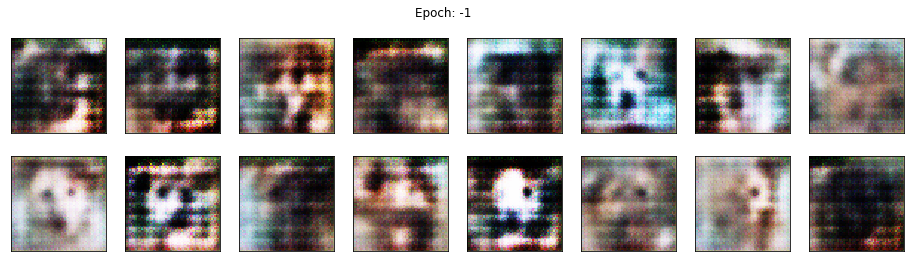

In [14]:
dogs = load_pickle('model_evaluation_samples.pkl')

def see_generated(epoch, dogs):
    fig, axes = plt.subplots(figsize = (16, 4), nrows=2, ncols = 8, sharey=True, sharex=True)
    fig.suptitle(f'Epoch: {epoch}') 

    for ax, img in zip(axes.flatten(), dogs[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        # images need to be rescaled to range (0-255)
        img = ((img +1)*255 / 2).astype(np.uint8)  
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img)

see_generated(-1, dogs)



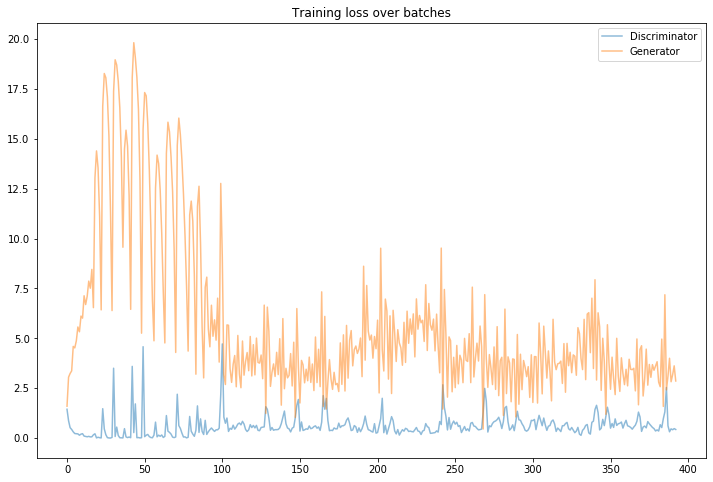

In [15]:
losses = load_pickle('model_evaluation_losses.pkl')
fig, ax = plt.subplots(figsize=(12, 8))
losses = np.array(losses)
plt.plot(losses.T[0], label = 'Discriminator',alpha=0.5)
plt.plot(losses.T[1], label = 'Generator', alpha=0.5)
plt.title('Training loss over batches')
plt.legend()

